# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [11]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [12]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [13]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 30

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [14]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.arange(0,30,2) # choosing every alternative image
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    # Crop the images and resize them. Note that the images are of 2 different shape 
                    # and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize(image,(120,120))
                    
                    # Normalise and feed in the image
                    image = image - np.percentile(image,5)/ (np.percentile(image,95) - np.percentile(image,5))
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # Remaining data points which are left after full batches
        rem_image = len(folder_list)%batch_size
        batch += 1
        if(rem_image!=0):
            batch_data = np.zeros((rem_image,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((rem_image,5)) # batch_labels is the one hot representation of the output
            for folder in range(rem_image): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    # Crop the images and resize them. Note that the images are of 2 different shape 
                    # and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize(image,(120,120))
                    
                    # Normalise and feed in the image
                    image = image - np.percentile(image,5)/ (np.percentile(image,95) - np.percentile(image,5))
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [15]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15
print ('# epochs =', num_epochs)
num_classes = 5
print ('# num classes =', num_classes)

# training sequences = 663
# validation sequences = 100
# epochs = 15
# num classes = 5


## Model Pre-setup
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [16]:
# Necessary imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Conv3D, Dense, Dropout, GRU, Flatten, LSTM, MaxPooling2D, MaxPooling3D, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

Let's now try to build different models each with different variations by adding/removing layers, fine tuning parameters, modifying the structure of the network, etc. to see how each one performs.

In [17]:
# To plot model build history
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [18]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [19]:
# Initialise callbacks to re-use
def getFilePath():
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)
        
    return model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=1)

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

## CNN+RNN Final Model

In [23]:
optimiser='sgd'
num_epochs = 30
print ('# epochs =', num_epochs)

# epochs = 30


In [31]:
rnn_model = Sequential()

rnn_model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(15, 120, 120, 3)))
rnn_model.add(TimeDistributed(BatchNormalization()))
rnn_model.add(TimeDistributed(MaxPooling2D((2, 2))))

rnn_model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
rnn_model.add(TimeDistributed(BatchNormalization()))
rnn_model.add(TimeDistributed(MaxPooling2D((2, 2))))

rnn_model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
rnn_model.add(TimeDistributed(BatchNormalization()))
rnn_model.add(TimeDistributed(MaxPooling2D((2, 2))))

rnn_model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
rnn_model.add(TimeDistributed(BatchNormalization()))
rnn_model.add(TimeDistributed(MaxPooling2D((2, 2))))

rnn_model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
rnn_model.add(TimeDistributed(BatchNormalization()))
rnn_model.add(TimeDistributed(MaxPooling2D((2, 2))))
rnn_model.add(TimeDistributed(Flatten()))

rnn_model.add(GRU(256))
        
rnn_model.add(Dense(128,activation='relu'))
rnn_model.add(Dropout(0.5))

rnn_model.add(Dense(64,activation='relu'))
rnn_model.add(Dropout(0.25))
rnn_model.add(Dense(num_classes, activation='softmax'))

In [32]:
rnn_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (rnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_32 (TimeDis (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_33 (TimeDis (None, 15, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_34 (TimeDis (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_35 (TimeDis (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_36 (TimeDis (None, 15, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_37 (TimeDis (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_38 (TimeDis (None, 15, 30, 30, 64)   

In [33]:
checkpoint = ModelCheckpoint(getFilePath(), monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

callbacks_list = [checkpoint, earlystop, LR]

In [34]:
history_rnn = rnn_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.6290 - categorical_accuracy: 0.2760
Epoch 00001: saving model to model_init_2021-08-0209_27_42.715839/model-00001-1.62901-0.27602-1.97272-0.19000.h5
23/23 [==============================] - 137s 6s/step - loss: 1.6290 - categorical_accuracy: 0.2760 - val_loss: 1.9727 - val_categorical_accuracy: 0.1900
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.3080 - categorical_accuracy: 0.4359
Epoch 00002: saving model to model_init_2021-08-0209_27_42.715839/model-00002-1.30799-0.43590-1.93535-0.25000.h5
23/23 [==============================] - 138s 6s/step - loss: 1.3080 - categorical_accuracy: 0.4359 - val_loss: 1.9354 - val_categorical_accuracy: 0.2500
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.1852 - categorical_accuracy: 0.5083
Epoch 00003: saving model to model_init_2021-08-0209_27_42.715839/model-00003-1.18518-0.50830-1.83234-0.25000.h5
23/23 [============================

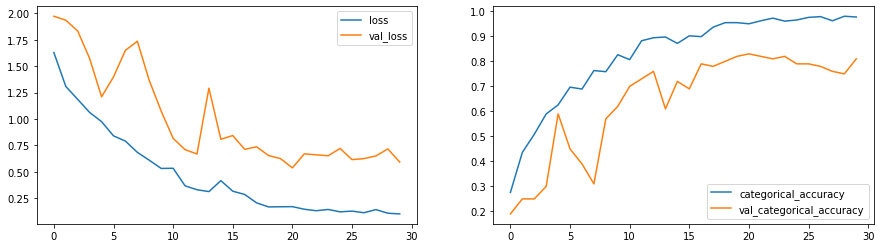

In [35]:
plot(history_rnn)

## Conv3D Final Model

In [19]:
filtersize=(3,3,3)
dense_neurons=256

conv3d_model = Sequential()
conv3d_model.add(Conv3D(32, filtersize, padding='same',input_shape=(15,120,120,3)))
conv3d_model.add(Activation('relu'))
conv3d_model.add(BatchNormalization())

conv3d_model.add(Conv3D(32, filtersize, padding='same',input_shape=(15,120,120,3)))
conv3d_model.add(Activation('relu'))
conv3d_model.add(BatchNormalization())

conv3d_model.add(MaxPooling3D(pool_size=(2, 2, 2)))

conv3d_model.add(Conv3D(64, filtersize, padding='same'))
conv3d_model.add(Activation('relu'))
conv3d_model.add(BatchNormalization())

conv3d_model.add(Conv3D(64, filtersize, padding='same'))
conv3d_model.add(Activation('relu'))
conv3d_model.add(BatchNormalization())

conv3d_model.add(Conv3D(64, filtersize, padding='same'))
conv3d_model.add(Activation('relu'))
conv3d_model.add(BatchNormalization())

conv3d_model.add(MaxPooling3D(pool_size=(2, 2, 2)))

conv3d_model.add(Flatten())
conv3d_model.add(Dense(dense_neurons,activation='relu'))
conv3d_model.add(BatchNormalization())
conv3d_model.add(Dropout(0.25))

conv3d_model.add(Dense(dense_neurons,activation='relu'))
conv3d_model.add(BatchNormalization())
conv3d_model.add(Dropout(0.25))

conv3d_model.add(Dense(num_classes,activation='softmax'))

In [20]:
conv3d_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (conv3d_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 15, 120, 120, 32)  2624      
_________________________________________________________________
activation_6 (Activation)    (None, 15, 120, 120, 32)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 15, 120, 120, 32)  128       
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 15, 120, 120, 32)  27680     
_________________________________________________________________
activation_7 (Activation)    (None, 15, 120, 120, 32)  0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 15, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 7, 60, 60, 32)    

In [21]:
checkpoint = ModelCheckpoint(getFilePath(), monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

callbacks_list = [checkpoint, LR]

In [22]:
conv3d_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.4119 - categorical_accuracy: 0.4977Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-08-0208_17_46.514952/model-00001-1.41188-0.49774-141.78842-0.23000.h5
23/23 [==============================] - 90s 4s/step - loss: 1.4119 - categorical_accuracy: 0.4977 - val_loss: 141.7884 - val_categorical_accuracy: 0.2300
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 0.9164 - categorical_accuracy: 0.6772
Epoch 00002: saving model to model_init_2021-08-0208_17_46.514952/model-00002-0.91636-0.67722-80.29002-0.20000.h5
23/23 [==============================] - 92s 4s/step - loss: 0.9164 - categorical_accuracy: 0.6772 - val_loss: 80.2900 - val_categorical_accuracy: 0.2000
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 0.7333 - categorical_accuracy: 0.7360
Epoch 00003:

# Appendix

This section contains all the models built as a part of the exploration process. The final models for each of RNN and Conv3D approch are the ones highlighted above. For testing different models, we've used 15 epochs for faster training purposes.

In [ ]:
num_epochs = 15
print ('# epochs =', num_epochs)

## Model 1: CNN+RNN Single Layer with 15 epochs

In [ ]:
model_1 = Sequential()

model_1.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'),input_shape=(15, 120, 120, 3)))
model_1.add(TimeDistributed(MaxPooling2D((2, 2))))
model_1.add(TimeDistributed(Flatten()))

model_1.add(GRU(32))
        
model_1.add(Dense(128,activation='relu'))
model_1.add(Dense(num_classes, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = 'Adam' # Let's test with Adam first

In [ ]:
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_1.summary())

In [ ]:
checkpoint = ModelCheckpoint(getFilePath(), monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

callbacks_list = [checkpoint, earlystop, LR]

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history_1 = model_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(history_1)

As we can clearly see, the model is very much underfitting and performs only as good as a naive model. Let's try to add more layers to the model and see if that helps.

## Model 2: Two layers CNN+RNN

In [ ]:
model_2 = Sequential()

model_2.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(15, 120, 120, 3)))
model_2.add(TimeDistributed(MaxPooling2D((2, 2))))

model_2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_2.add(TimeDistributed(MaxPooling2D((2, 2))))
model_2.add(TimeDistributed(Flatten()))

model_2.add(GRU(32))
        
model_2.add(Dense(128,activation='relu'))
model_2.add(Dense(num_classes, activation='softmax'))

In [ ]:
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

In [ ]:
checkpoint = ModelCheckpoint(getFilePath(), monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

callbacks_list = [checkpoint, earlystop, LR]

In [ ]:
history_2 = model_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(history_2)

## Model 3: Two layers CNN+RNN+Batch Normalisation

In [ ]:
model_3 = Sequential()

model_3.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(15, 120, 120, 3)))
model_3.add(TimeDistributed(BatchNormalization()))
model_3.add(TimeDistributed(MaxPooling2D((2, 2))))

model_3.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_3.add(TimeDistributed(BatchNormalization()))
model_3.add(TimeDistributed(MaxPooling2D((2, 2))))
model_3.add(TimeDistributed(Flatten()))

model_3.add(GRU(32))
        
model_3.add(Dense(128,activation='relu'))
model_3.add(Dense(num_classes, activation='softmax'))

In [ ]:
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3.summary())

In [ ]:
checkpoint = ModelCheckpoint(getFilePath(), monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

callbacks_list = [checkpoint, earlystop, LR]

In [ ]:
history_3 = model_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(history_3)

Adding batch normalisation has proven to improve the accuracy by a huge margin and this is mainly due to the fact that there would be a huge deviation in the data and normalising helps in closing that gap. But we can see that now the model has overfitted on the training data, since there's a huge gap of over 25% between the training and validation accuracy.

## Model 4: Two layers CNN+RNN+Batch Normalisation+Dropout

In [ ]:
model_4 = Sequential()

model_4.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(15, 120, 120, 3)))
model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D((2, 2))))
model_4.add(TimeDistributed(Flatten()))

model_4.add(GRU(32))
        
model_4.add(Dense(128,activation='relu'))
model_4.add(Dropout(0.25))
model_4.add(Dense(num_classes, activation='softmax'))

In [ ]:
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_4.summary())

In [ ]:
checkpoint = ModelCheckpoint(getFilePath(), monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

callbacks_list = [checkpoint, earlystop, LR]

In [ ]:
history_4 = model_4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(history_4)

Adding dropout has reduced the overfitting to an extent, but as a side effect, the model seems to have not adapted well to both the train and test data. We will now try out the same model with SGD optimiser to see if changing the optimiser has any effect on the training.

## Model 5: Two layers CNN+RNN+Batch Normalisation+Dropout (SGD Optimiser)

In [ ]:
model_5 = Sequential()

model_5.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(15, 120, 120, 3)))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))

model_5.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))
model_5.add(TimeDistributed(Flatten()))

model_5.add(GRU(32))
        
model_5.add(Dense(128,activation='relu'))
model_5.add(Dropout(0.25))
model_5.add(Dense(num_classes, activation='softmax'))

In [ ]:
model_5.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_5.summary())

In [ ]:
checkpoint = ModelCheckpoint(getFilePath(), monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

callbacks_list = [checkpoint, earlystop, LR]

In [ ]:
history_5 = model_5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(history_5)

SGD seems to perform better, even though there's a slight overfitting. Let us try increasing the complexity of the model and add dropouts to reduce this. Also we can see that even after 15 epochs, the model is still growing, so running with more no. of epochs might give us better results on the model.

## Model 6: Multi Layer CNN+RNN+Batch Normalisation+Dropout (fully packed model)

In [ ]:
optimiser='sgd'
num_epochs = 30
print ('# epochs =', num_epochs)

In [ ]:
model_6 = Sequential()

model_6.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(15, 120, 120, 3)))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2))))

model_6.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2))))

model_6.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2))))

model_6.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2))))

model_6.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2))))
model_6.add(TimeDistributed(Flatten()))

model_6.add(GRU(256))
        
model_6.add(Dense(128,activation='relu'))
model_6.add(Dropout(0.25))

model_6.add(Dense(64,activation='relu'))
model_6.add(Dropout(0.25))
model_6.add(Dense(num_classes, activation='softmax'))

In [ ]:
model_6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_6.summary())

In [ ]:
checkpoint = ModelCheckpoint(getFilePath(), monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

callbacks_list = [checkpoint, earlystop, LR]

In [ ]:
history_6 = model_6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(history_6)

We can see that the model fits overall really well but still is overfitting on the training data. Let's try increasing the dropout a bit to see if that helps in avoiding this.

As we can clearly see from the graph, the overfitting has been reduced a bit compared to the previous model. Even though it is still highly inclined towards train data, it generalises comparatively better to the previous one.

## Model 7: Multi Layer CNN+RNN+Batch Normalisation+Increased Dropout (fully packed model)

In [ ]:
model_7 = Sequential()

model_7.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(15, 120, 120, 3)))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D((2, 2))))

model_7.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D((2, 2))))

model_7.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D((2, 2))))

model_7.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D((2, 2))))

model_7.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D((2, 2))))
model_7.add(TimeDistributed(Flatten()))

model_7.add(GRU(256))
        
model_7.add(Dense(128,activation='relu'))
model_7.add(Dropout(0.5))

model_7.add(Dense(64,activation='relu'))
model_7.add(Dropout(0.25))
model_7.add(Dense(num_classes, activation='softmax'))

In [ ]:
model_7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_7.summary())

In [ ]:
checkpoint = ModelCheckpoint(getFilePath(), monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

callbacks_list = [checkpoint, earlystop, LR]

In [ ]:
history_7 = model_7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(history_7)

Now that we have tried out various models using CNN+RNN stack, let's now try out Convolution 3D models to see if they help in avoiding overfitting or getting overall better output.

## Model 1: Conv3D Single Layer

In [ ]:
optimiser = 'Adam'

In [ ]:
filtersize=(3,3,3)
dense_neurons=256

model_1 = Sequential()
model_1.add(Conv3D(32, filtersize, padding='same',input_shape=(15,120,120,3)))
model_1.add(Activation('relu'))

model_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_1.add(Flatten())
model_1.add(Dense(dense_neurons,activation='relu'))

model_1.add(Dense(num_classes,activation='softmax'))

In [ ]:
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_1.summary())

In [ ]:
checkpoint = ModelCheckpoint(getFilePath(), monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

callbacks_list = [checkpoint, earlystop, LR]

In [ ]:
history_1 = model_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(history_1)

## Model 2: Conv3D Two Layers

In [ ]:
filtersize=(3,3,3)
dense_neurons=256

model_2 = Sequential()
model_2.add(Conv3D(32, filtersize, padding='same',input_shape=(15,120,120,3)))
model_2.add(Activation('relu'))

model_2.add(Conv3D(32, filtersize, padding='same',input_shape=(15,120,120,3)))
model_2.add(Activation('relu'))

model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))


model_2.add(Flatten())
model_2.add(Dense(dense_neurons,activation='relu'))

model_2.add(Dense(num_classes,activation='softmax'))

In [ ]:
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

In [ ]:
checkpoint = ModelCheckpoint(getFilePath(), monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

callbacks_list = [checkpoint, LR]

In [ ]:
history_2 = model_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(history_2)

## Model 3:  Two Layers Conv3D+Batch Normalisation

In [ ]:
filtersize=(3,3,3)
dense_neurons=256

model_3 = Sequential()
model_3.add(Conv3D(32, filtersize, padding='same',input_shape=(15,120,120,3)))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())

model_3.add(Conv3D(32, filtersize, padding='same',input_shape=(15,120,120,3)))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())

model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))


model_3.add(Flatten())
model_3.add(Dense(dense_neurons,activation='relu'))
model_3.add(BatchNormalization())

model_3.add(Dense(num_classes,activation='softmax'))

In [ ]:
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3.summary())

In [ ]:
checkpoint = ModelCheckpoint(getFilePath(), monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

callbacks_list = [checkpoint, LR]

In [ ]:
history_3 = model_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(history_3)

As we can see here by adding batch normalization validation accuracy has increased significantly. However it has now completely overfitted on train data. Let's add dropouts to prevent the overfitting.

## Model 4:  Two Layers Conv3D+BatchNormalisation+Dropout

In [ ]:
filtersize=(3,3,3)
dense_neurons=256

model_4 = Sequential()
model_4.add(Conv3D(32, filtersize, padding='same',input_shape=(15,120,120,3)))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())

model_4.add(Conv3D(32, filtersize, padding='same',input_shape=(15,120,120,3)))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())

model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_4.add(Dropout(0.5))


model_4.add(Flatten())
model_4.add(Dense(dense_neurons,activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.5))

model_4.add(Dense(num_classes,activation='softmax'))

In [ ]:
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_4.summary())

In [ ]:
checkpoint = ModelCheckpoint(getFilePath(), monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

callbacks_list = [checkpoint, LR]

In [ ]:
history_4 = model_4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(history_4)

## Model 5: Multi Layer Conv3D+Batch Normalisation+Dropout (fully packed model)

In [ ]:
num_epochs = 30
print ('# epochs =', num_epochs)

In [ ]:
filtersize=(3,3,3)
dense_neurons=256

model_5 = Sequential()
model_5.add(Conv3D(32, filtersize, padding='same',input_shape=(15,120,120,3)))
model_5.add(Activation('relu'))
model_5.add(BatchNormalization())

model_5.add(Conv3D(32, filtersize, padding='same',input_shape=(15,120,120,3)))
model_5.add(Activation('relu'))
model_5.add(BatchNormalization())

model_5.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_5.add(Conv3D(64, filtersize, padding='same'))
model_5.add(Activation('relu'))
model_5.add(BatchNormalization())

model_5.add(Conv3D(64, filtersize, padding='same'))
model_5.add(Activation('relu'))
model_5.add(BatchNormalization())

model_5.add(Conv3D(64, filtersize, padding='same'))
model_5.add(Activation('relu'))
model_5.add(BatchNormalization())


model_5.add(MaxPooling3D(pool_size=(2, 2, 2)))


model_5.add(Flatten())
model_5.add(Dense(dense_neurons,activation='relu'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.25))

model_5.add(Dense(dense_neurons,activation='relu'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.25))

model_5.add(Dense(num_classes,activation='softmax'))

In [ ]:
model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_5.summary())

In [ ]:
checkpoint = ModelCheckpoint(getFilePath(), monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

callbacks_list = [checkpoint, LR]

In [ ]:
history_5 = model_5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(history_5)